## Import Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

## Load and Explore Data

In [17]:
# Load data
train_df = pd.read_csv('Dataset/train.csv')
test_df = pd.read_csv('Dataset/test.csv')

print("Original shapes:")
print(f"Train: {train_df.shape}, Test: {test_df.shape}")

# Display basic info
print("\nTrain dataset info:")
print(train_df.head())

Original shapes:
Train: (1460, 81), Test: (1459, 80)

Train dataset info:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     1

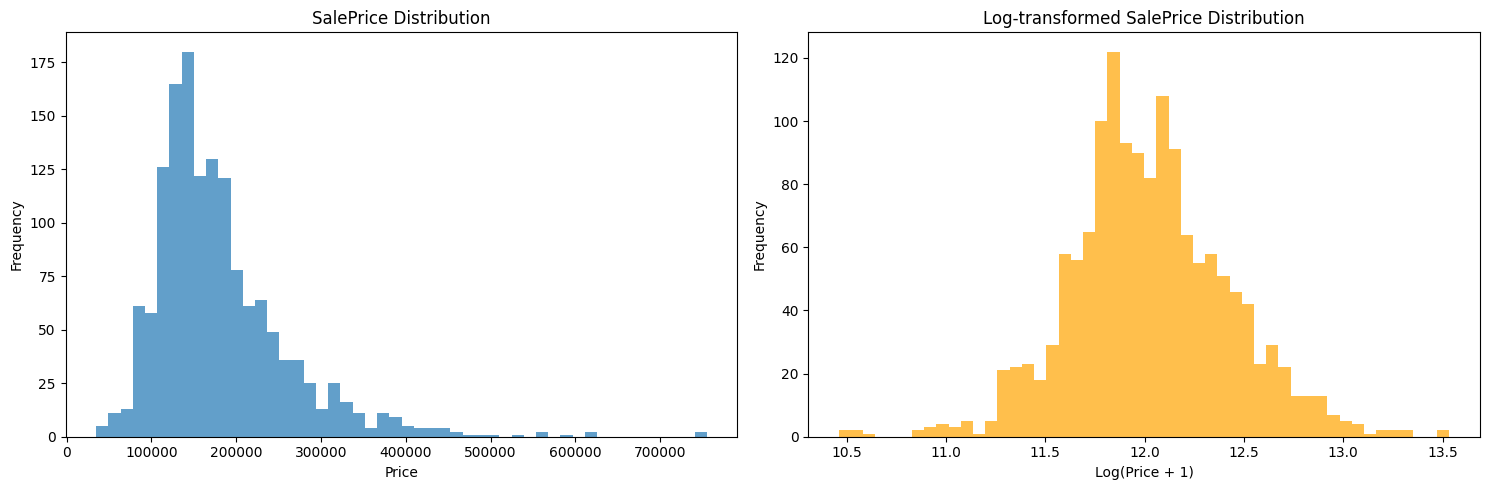

SalePrice skewness: 1.881
Log SalePrice skewness: 0.121


In [18]:
# Visualize target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution
axes[0].hist(train_df['SalePrice'], bins=50, alpha=0.7)
axes[0].set_title('SalePrice Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Log-transformed distribution
axes[1].hist(np.log1p(train_df['SalePrice']), bins=50, alpha=0.7, color='orange')
axes[1].set_title('Log-transformed SalePrice Distribution')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"SalePrice skewness: {stats.skew(train_df['SalePrice']):.3f}")
print(f"Log SalePrice skewness: {stats.skew(np.log1p(train_df['SalePrice'])):.3f}")

,DataType,MissingValues,UniqueValues
PoolQC,object,1453,3
MiscFeature,object,1406,4
Alley,object,1369,2
Fence,object,1179,4
MasVnrType,object,872,3
...,...,...,...
ExterQual,object,0,4
Exterior2nd,object,0,16
Exterior1st,object,0,15
RoofMatl,object,0,8


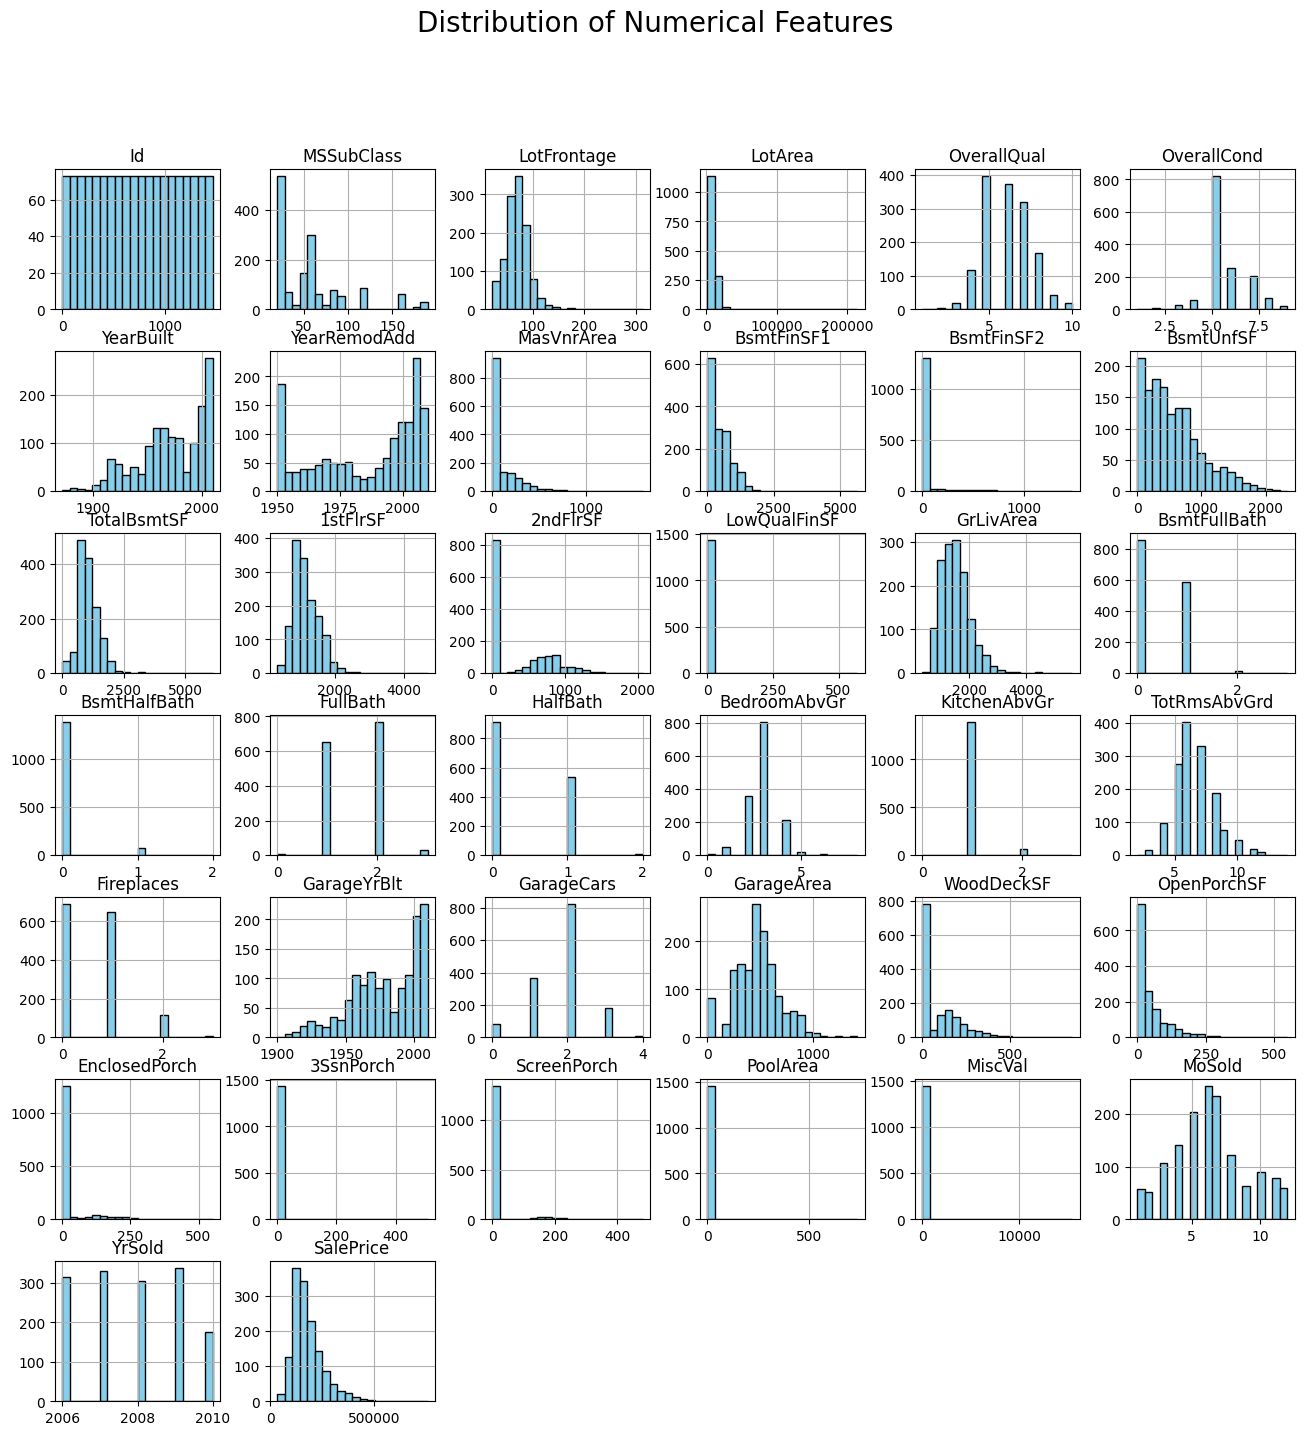

In [19]:


def explore_data(train_df):
    exploration = pd.DataFrame({
        "DataType": train_df.dtypes,
        "MissingValues": train_df.isnull().sum(),
        "UniqueValues": train_df.nunique()
    })
    exploration = exploration.sort_values(by="MissingValues", ascending=False)
    return exploration

exploration_summary = explore_data(train_df)

display(exploration_summary.head(81))


# Distribution of Numerical Features ---
numeric = train_df.select_dtypes(include=["int64", "float64"]).columns
train_df[numeric].hist(bins=20, figsize=(16,16), color="skyblue", edgecolor="black")
plt.suptitle("Distribution of Numerical Features", size=20)
plt.show()


## Data Preprocessing and Feature Engineering

In [ ]:
# Separate train and test data properly
train_len = len(train_df)
y = train_df['SalePrice']
test_ids = test_df['Id']

# Keep original separate datasets
X_train_orig = train_df.drop(['SalePrice', 'Id'], axis=1)
X_test_orig = test_df.drop(['Id'], axis=1)

print(f"Original shapes - Train: {X_train_orig.shape}, Test: {X_test_orig.shape}")
print(f"Missing values - Train: {X_train_orig.isnull().sum().sum()}, Test: {X_test_orig.isnull().sum().sum()}")

Combined data shape: (2919, 79)
Missing values before preprocessing: 15707


In [ ]:
class HousePricePreprocessor(BaseEstimator, TransformerMixin):
    """Preprocessing class that fits only on training data to avoid data leakage"""
    
    def __init__(self):
        self.neighborhood_medians = {}
        self.categorical_mappings = {}
        self.rare_categories = {}
        self.feature_medians = {}
        self.quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
        self.bsmt_fin_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
        self.garage_fin_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
        self.func_map = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}
        self.categorical_columns = []
        
    def fit(self, X, y=None):
        """Fit preprocessor on training data only"""
        X = X.copy()
        
        # Calculate neighborhood-based medians for LotFrontage (fit on train only)
        if 'LotFrontage' in X.columns:
            grouped = X.groupby(['Neighborhood', 'LotConfig'])['LotFrontage']
            self.neighborhood_medians = grouped.median().to_dict()
            self.feature_medians['LotFrontage'] = X['LotFrontage'].median()
        
        # Identify rare categories based on training data only
        for col in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
            if col in X.columns:
                counts = X[col].value_counts()
                self.rare_categories[col] = counts[counts < 10].index.tolist()
        
        # Store medians for other features
        numeric_cols = ['GarageYrBlt']
        for col in numeric_cols:
            if col in X.columns:
                self.feature_medians[col] = X[col].median()
        
        # Get categorical columns for one-hot encoding
        temp_df = self._basic_preprocessing(X)
        self.categorical_columns = temp_df.select_dtypes(include=['object']).columns.tolist()
        
        return self
    
    def transform(self, X):
        """Transform data using parameters fitted on training data"""
        X = X.copy()
        return self._basic_preprocessing(X)
    
    def _basic_preprocessing(self, df):
        """Core preprocessing logic"""
        df = df.copy()
        
        # 1. Handle missing values strategically
        # LotFrontage with neighborhood-based imputation
        if 'LotFrontage' in df.columns:
            for (neighborhood, lot_config), median_val in self.neighborhood_medians.items():
                mask = (df['Neighborhood'] == neighborhood) & (df['LotConfig'] == lot_config)
                df.loc[mask & df['LotFrontage'].isnull(), 'LotFrontage'] = median_val
            
            # Fill remaining with overall median
            df['LotFrontage'] = df['LotFrontage'].fillna(self.feature_medians.get('LotFrontage', 0))
        
        # Group rare categories
        for col in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
            if col in df.columns and col in self.rare_categories:
                mask = df[col].isin(self.rare_categories[col])
                df.loc[mask, col] = 'Rare'
        
        # Basement features
        bsmt_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
        for col in bsmt_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)
                
        bsmt_cat_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
        for col in bsmt_cat_cols:
            if col in df.columns:
                df[col] = df[col].fillna('None')
        
        # Garage features
        garage_cols = ['GarageArea', 'GarageCars']
        for col in garage_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)
                
        garage_cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        for col in garage_cat_cols:
            if col in df.columns:
                df[col] = df[col].fillna('None')
        
        if 'GarageYrBlt' in df.columns and 'YearBuilt' in df.columns:
            garage_median = self.feature_medians.get('GarageYrBlt', df['YearBuilt'])
            df['GarageYrBlt'] = df['GarageYrBlt'].fillna(garage_median)
        
        # Other missing values
        df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
        df['MasVnrType'] = df['MasVnrType'].fillna('None')
        df['Electrical'] = df['Electrical'].fillna('SBrkr')
        
        # Fill remaining categorical NAs
        cat_cols = df.select_dtypes(include=['object']).columns
        for col in cat_cols:
            df[col] = df[col].fillna('None')
        
        # Fill remaining numerical NAs
        num_cols = df.select_dtypes(include=[np.number]).columns
        for col in num_cols:
            df[col] = df[col].fillna(0)
        
        # 2. Create new features
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
        df['TotalBaths'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
        df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
        
        # Age features
        df['HouseAge'] = df['YrSold'] - df['YearBuilt']
        df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
        df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
        
        # Binary features
        df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
        df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
        df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
        df['HasPorch'] = (df['TotalPorchSF'] > 0).astype(int)
        
        # 3. Convert ordinal categorical variables to numerical
        # Quality features
        qual_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                     'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
        
        for col in qual_cols:
            if col in df.columns:
                df[col] = df[col].map(self.quality_map).fillna(0)
        
        # Basement exposure
        if 'BsmtExposure' in df.columns:
            bsmt_exp_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
            df['BsmtExposure'] = df['BsmtExposure'].map(bsmt_exp_map).fillna(0)
        
        # Basement finish type
        for col in ['BsmtFinType1', 'BsmtFinType2']:
            if col in df.columns:
                df[col] = df[col].map(self.bsmt_fin_map).fillna(0)
        
        # Garage finish
        if 'GarageFinish' in df.columns:
            df['GarageFinish'] = df['GarageFinish'].map(self.garage_fin_map).fillna(0)
        
        # Functional
        if 'Functional' in df.columns:
            df['Functional'] = df['Functional'].map(self.func_map).fillna(0)
        
        # 4. Create interaction features
        df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
        df['GrLivArea_OverallQual'] = df['GrLivArea'] * df['OverallQual']
        df['GarageArea_GarageCars'] = df['GarageArea'] * df['GarageCars']
        df['KitchenQual_TotRmsAbvGrd'] = df['KitchenQual'] * df['TotRmsAbvGrd']
        df['LotArea_LotFrontage'] = df['LotArea'] * df['LotFrontage']
        df['TotalSF_OverallCond'] = df['TotalSF'] * df['OverallCond']
        
        # 5. Handle remaining categorical variables with one-hot encoding
        remaining_cat_cols = df.select_dtypes(include=['object']).columns.tolist()
        
        if remaining_cat_cols:
            df = pd.get_dummies(df, columns=remaining_cat_cols, dummy_na=True, drop_first=True)
        
        return df

In [22]:
# Apply preprocessing without data leakage
print("Applying preprocessing pipeline...")

# Initialize and fit preprocessor on training data only
preprocessor = HousePricePreprocessor()
preprocessor.fit(X_train_orig)

# Transform both train and test using fitted preprocessor
X_train_processed = preprocessor.transform(X_train_orig)
X_test_processed = preprocessor.transform(X_test_orig)

print(f"\nAfter preprocessing:")
print(f"Train shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")
print(f"Train missing values: {X_train_processed.isnull().sum().sum()}")
print(f"Test missing values: {X_test_processed.isnull().sum().sum()}")

# Ensure both datasets have the same columns
train_cols = set(X_train_processed.columns)
test_cols = set(X_test_processed.columns)

missing_in_test = train_cols - test_cols
missing_in_train = test_cols - train_cols

if missing_in_test:
    print(f"\nColumns missing in test: {len(missing_in_test)}")
    for col in missing_in_test:
        X_test_processed[col] = 0
        
if missing_in_train:
    print(f"Columns missing in train: {len(missing_in_train)}")
    for col in missing_in_train:
        X_train_processed[col] = 0

# Reorder columns to match
X_test_processed = X_test_processed[X_train_processed.columns]

print(f"\nFinal shapes after alignment:")
print(f"Train: {X_train_processed.shape}, Test: {X_test_processed.shape}")
print(f"Columns match: {list(X_train_processed.columns) == list(X_test_processed.columns)}")


After feature engineering: (2919, 254)
Missing values: 0
Data types: bool       188
int64       43
float64     19
int32        4
Name: count, dtype: int64


## Prepare Data for Modeling

In [ ]:
# Use the properly preprocessed data
X_train = X_train_processed
X_test = X_test_processed

# Log transform the target
y_log = np.log1p(y)

print(f"Final shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Target shape: {y_log.shape}")

# Split training data for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_log, test_size=0.2, random_state=42)

print(f"\nTrain/Validation split:")
print(f"X_tr: {X_tr.shape}, X_val: {X_val.shape}")
print(f"y_tr: {y_tr.shape}, y_val: {y_val.shape}")

# Verify no data leakage
print(f"\nData integrity check:")
print(f"All features are numeric: {X_train.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()}")
print(f"No missing values in train: {X_train.isnull().sum().sum() == 0}")
print(f"No missing values in test: {X_test.isnull().sum().sum() == 0}")

Final shapes - X_train: (1460, 254), X_test: (1459, 254)

Train/Validation split:
X_tr: (1168, 254), X_val: (292, 254)
y_tr: (1168,), y_val: (292,)


## Custom Transformers and Pipeline Setup

In [24]:
# Custom transformer for handling skewed features
class SkewnessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=0.75):
        self.skew_threshold = skew_threshold
        self.skewed_features = []
        self.lam_values = {}
    
    def fit(self, X, y=None):
        # Identify skewed features
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        skewness = X[numeric_cols].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
        self.skewed_features = skewness[abs(skewness) > self.skew_threshold].index.tolist()
        
    
        
        # Calculate lambda values for Box-Cox transformation
        for col in self.skewed_features:
            self.lam_values[col] = 0.15 
            
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.skewed_features:
            if col in X_transformed.columns:
                X_transformed[col] = boxcox1p(X_transformed[col], self.lam_values[col])
        return X_transformed


In [25]:
# Create advanced preprocessing pipeline
def create_advanced_pipeline(model, use_skew_transform=True):
    steps = []
    
    if use_skew_transform:
        steps.append(('skew_transform', SkewnessTransformer()))
    
    steps.extend([
        ('scaler', RobustScaler()),  
        ('model', model)
    ])
    
    return Pipeline(steps)

# Define multiple models for ensemble
models = {
  
    'ridge': Ridge(alpha=10),
    'lasso': Lasso(alpha=0.0005, random_state=42),
    'elastic': ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42),
   
    'gb': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
}


## Model Training and Validation

In [26]:
# Train and validate models
model_scores = {}
trained_models = {}


for name, model in models.items():
    print(f"Training {name.upper()}...")
    
    try:
        pipeline = create_advanced_pipeline(model)
        pipeline.fit(X_tr, y_tr)
        
        # Validate
        y_pred_val = pipeline.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred_val, squared=False)
        
        model_scores[name] = rmse
        trained_models[name] = pipeline
        
        print(f"{name.upper()} RMSE: {rmse:.4f}")
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue
    
    print("-" * 50)

# Find best single model
if model_scores:
    best_model_name = min(model_scores, key=model_scores.get)
    print(f"\nBest single model: {best_model_name.upper()} with RMSE: {model_scores[best_model_name]:.4f}")
  
else:
    print("No models were successfully trained!")

Training RIDGE...
RIDGE RMSE: 0.1288
--------------------------------------------------
Training LASSO...
LASSO RMSE: 0.1330
--------------------------------------------------
Training ELASTIC...
ELASTIC RMSE: 0.1335
--------------------------------------------------
Training GB...
GB RMSE: 0.1396
--------------------------------------------------

Best single model: RIDGE with RMSE: 0.1288


## Ensemble Predictions

In [27]:
# Create ensemble predictions function
def create_ensemble_predictions(models_dict, X_data):
    """Create ensemble predictions using different methods"""
    predictions = {}
    for name, pipeline in models_dict.items():
        predictions[name] = pipeline.predict(X_data)
    


    ensemble_pred = np.mean([pred for pred in predictions.values()], axis=0)
    
    return ensemble_pred

# Create ensemble predictions for validation
if trained_models:
    
    ensemble_val_pred = create_ensemble_predictions(trained_models, X_val)
    ensemble_rmse = mean_squared_error(y_val, ensemble_val_pred, squared=False)
    
    print(f"\nEnsemble Validation RMSE: {ensemble_rmse:.4f}")
    
    # Compare with best single model
    best_single_rmse = min(model_scores.values())
    improvement = best_single_rmse - ensemble_rmse
    print(f"Improvement over best single model: {improvement:.4f}")
else:
    print("No trained models available for ensemble!")


Ensemble Validation RMSE: 0.1300
Improvement over best single model: -0.0012


## Final Model Training and Predictions

In [28]:
# Retrain models on full training data
print("Retraining models on full training data...\n")
final_models = {}

for name, model in models.items():
    if name in model_scores: 
    
        try:
            pipeline = create_advanced_pipeline(model)
            pipeline.fit(X_train, y_log)
            final_models[name] = pipeline
            print(f"{name.upper()} retrained successfully")
        except Exception as e:
            print(f"Error retraining {name}: {str(e)}")
            continue


Retraining models on full training data...

RIDGE retrained successfully
LASSO retrained successfully
ELASTIC retrained successfully
GB retrained successfully


In [29]:
# Generate final predictions
if final_models:
    print("Generating final ensemble predictions...")
    
    # Final ensemble predictions on test set
    ensemble_test_pred = create_ensemble_predictions(final_models, X_test)
    
    # Convert back from log scale
    final_predictions = np.expm1(ensemble_test_pred)
    
    # Create submission file
    submission = pd.DataFrame({
        'Id': test_ids,
        'SalePrice': final_predictions
    })
    
    
    display(submission.head(20))
    

    
else:
    print("No final models available for predictions!")

Generating final ensemble predictions...


,Id,SalePrice
0,1461,114281.793530
1,1462,155228.613016
2,1463,180802.044193
3,1464,195039.049733
4,1465,198827.400149
5,1466,170820.138585
6,1467,178187.944927
7,1468,164311.996324
8,1469,192878.723943
9,1470,121454.572224
